2004.7489345090898
226


C:\Users\miron\AppData\Local\Temp\ipykernel_11420\1323266755.py:40: RuntimeWarning: divide by zero encountered in power
  res = pow(np.sqrt(fx**2+fy**2), -11./3.)
C:\Users\miron\AppData\Local\Temp\ipykernel_11420\1323266755.py:117: RuntimeWarning: invalid value encountered in true_divide
  res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)
C:\Users\miron\AppData\Local\Temp\ipykernel_11420\1323266755.py:53: RuntimeWarning: invalid value encountered in multiply
  res = tmp_res * S


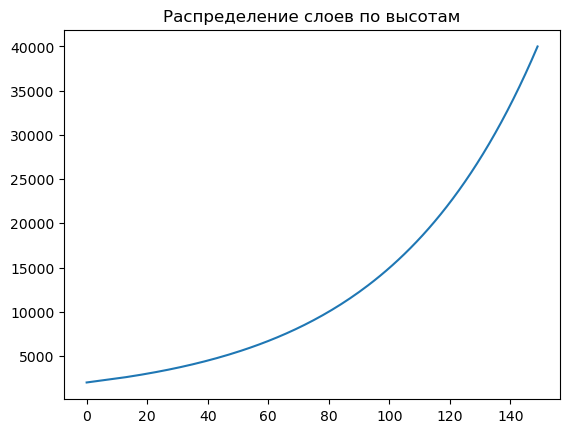

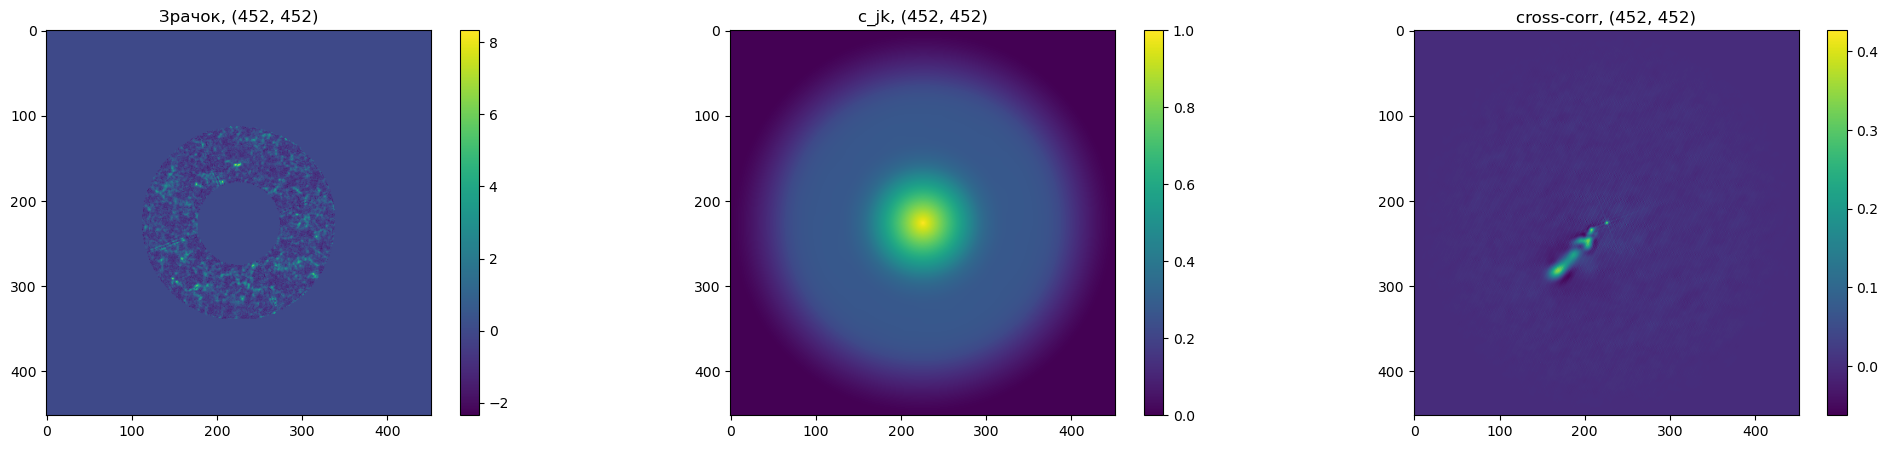

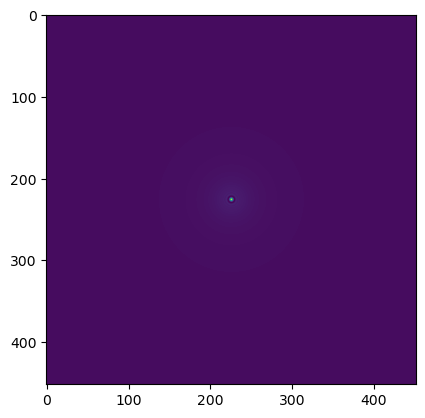

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from IPython.display import clear_output
from bisect import bisect_left


resp_f = np.loadtxt('C:/astro/domecam/resp_f.gz')

def sfilter(z=None):
    global nx, res_fft, omega_new_tmp
#     omega = z * omega_tmp # аргумент, шаг по частоте, [м^-1]
    omega_new = np.interp(z * omega_tmp, omega_new_tmp, res_fft)
    omega_new = np.resize(omega_new, (nx, nx))
    return omega_new

def c_jk(data):
    nx = data.shape[0]
    I0c = (data != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx


def aperture_func(fx, fy, delta): 
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    res[np.isnan(res)] = 0
    return res

def aperture_func2(fx, fy, exp_time, Vx, Vy):
    global A_f
    res = A_f * np.sinc(exp_time*(Vx*fx+Vy*fy))**2
    return res
    
def abs_f(fx, fy):
    res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    res[np.isnan(res)] = 0
    return res

def gamma_poly(X, Y, Vx, Vy, Cn2, z):
    global cjk, tmp_res, t, tmp_int, a1
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta 
        
    S = sfilter(z=z)  

    res = tmp_res * S
    res[np.isnan(res)] = 0
    
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    res = Cn2 * res * tmp_int   
#     res = shift(res, (-Ypix, Xpix), order=1) # 0.005 sec if order=1
    res = res * cjk
    return res


a1 = 4*np.logspace(2.7, 4, num=150, base=10)
print(a1[0])
a1[0]=2000
plt.plot(a1)
plt.title('Распределение слоев по высотам')

D = 2.5
latency = 4
sec_per_frame = 0.01
z_0 = 2000
Cn2 = 1*pow(10, -13)

pupil = np.loadtxt('C:/astro/domecam/frame.gz')
data = np.loadtxt('C:/astro/domecam/data_corr4.gz')
pupil_pix = pupil.shape[0]//2
print(pupil_pix)
# a = int(2*pupil.shape[0]+1 - data.shape[0])//2
# b = int(2*pupil.shape[1]+1 - data.shape[1])//2
# data = np.pad(data, ((a, a), (b, b)), 'constant', constant_values=(0))

cjk, nx = c_jk(pupil)
f_scale = pupil_pix/(D*nx)
delta = D/pupil_pix 

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy

f_11_3 = abs_f(fx, fy)
A_f = aperture_func(fx, fy, delta)
A_f2 = aperture_func2(fx, fy, 0.002, 15, -15)
tmp_res = A_f * f_11_3

t = sec_per_frame * latency
const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
tmp_int=const * pow(f_scale, 2) * pow(nx, 2)

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

# ------------ preomega ----------
lambda_max=resp_f[0][-1]
f_lambda=resp_f[1]
D=D
coeff=100
k = 1000*coeff
lambda_max_new = int(lambda_max*coeff)
lambdas = np.linspace(0, lambda_max_new, k) * pow(10, -9) # [м]

tail = np.zeros((len(lambdas) - len(f_lambda)))
f_lambda_new = np.append(f_lambda, tail)
res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)
res_fft[np.isnan(res_fft)] = 0

delta_lambdas = (lambda_max_new / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

delta = D/pupil.shape[0] # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

f_abs = np.sqrt(pow(fx, 2) + pow(fy, 2))
omega_tmp=0.5 * pow(f_abs, 2)
omega_tmp=np.ravel(omega_tmp)
omega_new_tmp=np.linspace(0, omega_lambdas_scale, 1000*100)
# -----------------

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr, {data.shape}')

plt.figure()
plt.imshow(gamma_poly(X, Y, 0, 0, 1e-13, 2000))

C:\Users\miron\AppData\Local\Temp\ipykernel_5872\1323266755.py:53: RuntimeWarning: invalid value encountered in multiply
  res = tmp_res * S


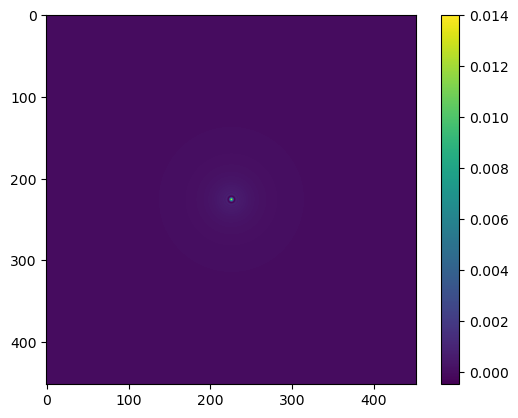

In [15]:
plt.imshow(gamma_poly(X, Y, 0, 0, 1e-13, 2000))
plt.colorbar()

28867.513459481288
290.0 29000.0


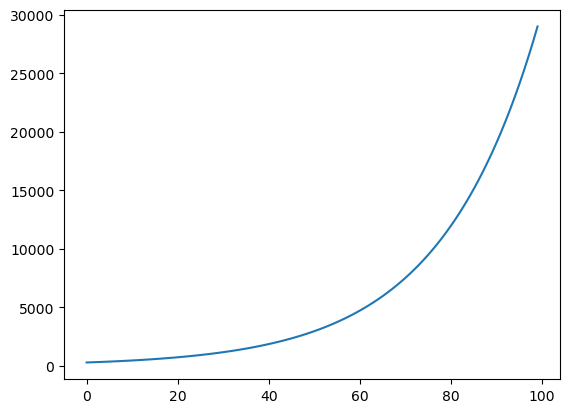

In [34]:
h_max = 25000
al = 60
z_max = h_max/(np.cos(np.deg2rad(90-al)))
print(z_max)
a1 = round((z_max/10000),1) * np.logspace(2, 4, num=100, base=10)
np.savetxt('C:/astro/domecam/z.gz', a1)
print(a1[0], a1[-1])
plt.plot(a1)

# gammas = np.ndarray(shape=(len(a1), cjk.shape[0], cjk.shape[1]))
# for i in range(len(a1)):
#     gammas[i] = gamma_poly(X, Y, 0, 0, 1e-13, a1[i])
# print('Done!')
# np.save(f'C:/astro/domecam/gammas.npy', gammas)
# del gammas
# gammas = np.load(f'C:/astro/domecam/gammas.npy')
# print(gammas.shape)

In [5]:
def multi_speckle_fit(params=None, ydata=None):
    global xdata, sec_per_frame, latency, delta, z_0
    def speckle_fit(xcoord, ycoord, Cn2_ex, z_dist, ydata): # аппроксимация одного слоя
        k=50
        def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
            x, y = M
            arr = np.zeros(x.shape)
            for i in range(len(args)//4):
                arr += gamma_poly(x, y, *args[i*4:i*4+4])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
            return arr
        
        params = [(xcoord, ycoord, Cn2_ex, z_dist)] # подгонка типа ввода параметров под функцию
        p0 = [p for prms in params for p in prms]
        st=time.perf_counter()
        
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        t = sec_per_frame * latency
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)

        fit = np.zeros(X.shape) # результирующее изображение
        xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
        ydata = ydata.ravel()
        
        popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-3, ycoord-3, 1*pow(10, -14), 0],
                                                             [xcoord+3, ycoord+3, 1*pow(10, -11), 50000]]) 
        print(f'Fitted parametrs: {popt[0]:.2f} {popt[1]:.2f} {popt[2]} {popt[3]:.2f}')
        for i in range(len(popt)//4):
            fit += gamma_poly(X, Y, *popt[i*4:i*4+4])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]

        print(f'Time: {time.perf_counter()-st:.4f}')
    
        t = sec_per_frame * latency
        Xpix = int(popt[0]*t/delta)
        Ypix = int(popt[1]*t/delta)
    
        return fit, Xpix, Ypix, popt[2], popt[3]
    
    myParams = [p for prms in params for p in prms]
    
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    t = sec_per_frame * latency

    for i in range(len(myParams)//4):
        print(f'Speckle fitting:', *myParams[i*4:i*4+4])
        fit, xcoord, ycoord, Cn2_fitted, z = speckle_fit(*myParams[i*4:i*4+4], ydata)
        res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
            (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        print(f'-max fitted value: {np.max(fit):.2f}')
        print(f'-max initial value: {np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]):.2f}')
        print('')
    
    return res, xcoord, ycoord, Cn2_fitted, z

Speckle fitting: 0 0 1e-13 2001


C:\Users\miron\AppData\Local\Temp\ipykernel_6724\512782271.py:56: RuntimeWarning: invalid value encountered in multiply
  res = tmp_res * S


Fitted parametrs: 0.02 0.03 9.99999999999999e-12 577.07
Time: 2.8112
-max fitted value: 0.46
-max initial value: 0.43

Speckle fitting: -7.5 -7.5 1e-13 10000
Fitted parametrs: -7.94 -7.66 2.0081294660379467e-12 9944.47
Time: 3.2196
-max fitted value: 0.36
-max initial value: 0.34

Speckle fitting: -15 -15 1e-13 10000
Fitted parametrs: -15.01 -15.00 9.999999999999998e-12 422.20
Time: 3.1381
-max fitted value: 0.07
-max initial value: 0.01

9.999999999999998e-12 
 422.2031479645215


NameError: name 'a' is not defined

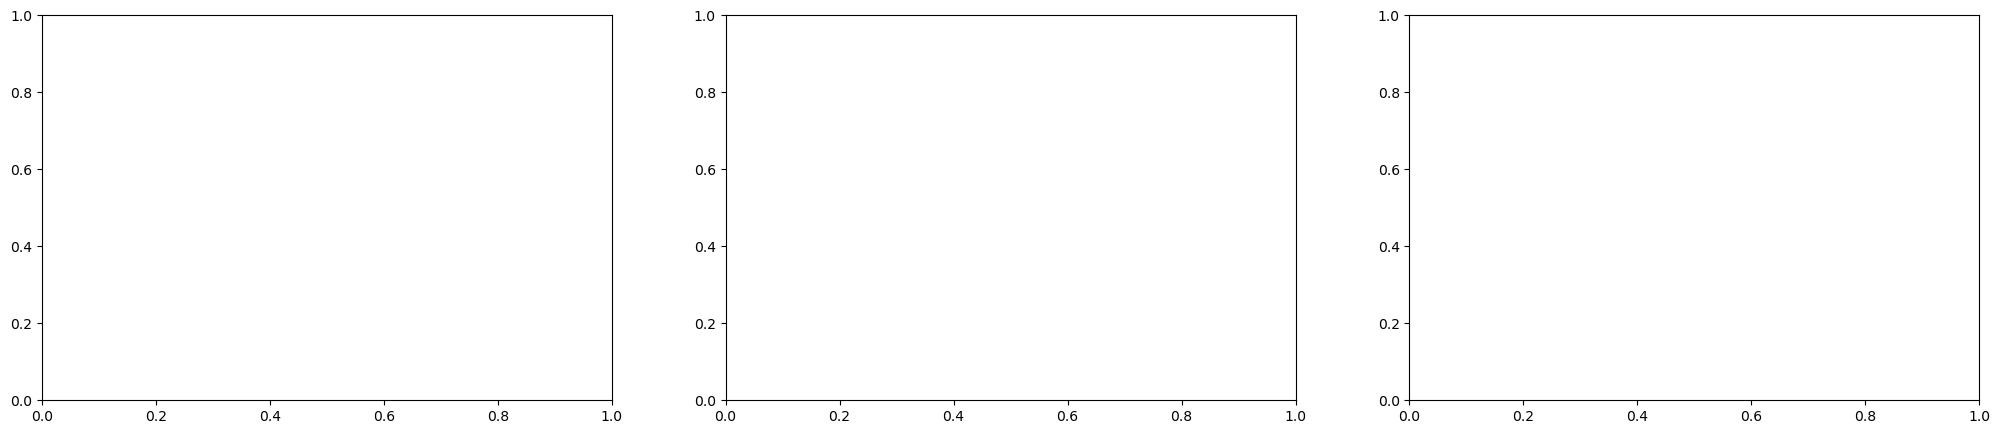

In [6]:
# myParams = [(Vx, Vy, Cn2, z)]
myParams = [( 0,   0,  1e-13, 2001),
            (-7.5, -7.5, 1e-13, 10000),
            (-15, -15,  1e-13, 10000)]

fit, speckle_x, speckle_y, Cn2_values, ztest = multi_speckle_fit(params=myParams, ydata=data)

print(Cn2_values,'\n', ztest)

# -----------------------------------------------------------
# lambda_=500*pow(10, -9) # нм
# k = 2*np.pi/lambda_
# r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2_values)), -3/5)
# print(' ')
# print('sum Cn2:', np.sum(Cn2_values))
# print('r0, sm:', 100*r0)
# print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)

# ------------ Отрисовка ---------------------------
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

cr = data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0]//2 # центр изображения
v = (D / pupil.shape[0]) / (latency * sec_per_frame)
x = np.round(v*np.linspace(-pupil.shape[0]//2+1, pupil.shape[0]//2, 5), 2)
y = np.round(v*np.linspace(-pupil.shape[0]//2+1, pupil.shape[0]//2, 5), 2)
y = np.flipud(y)

fig.colorbar(ax.imshow(data[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax)
ax.set_title('Исходные данные')

# for i in range(len(speckle_x)):
#     ax.scatter(cr+speckle_x[i], cr-speckle_y[i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
    
fig.colorbar(ax2.imshow(fit[a:fit.shape[0]-a, b:fit.shape[1]-b]), ax=ax2)
ax2.set_title('Апроксимация')
# ax2.set_xticks(np.linspace(0, fit[a:fit.shape[0]-a, b:fit.shape[1]-b].shape[1], 5))
# ax2.set_yticks(np.linspace(0, fit[a:fit.shape[0]-a, b:fit.shape[1]-b].shape[0], 5))
# ax2.set_xticklabels(x)
# ax2.set_yticklabels(y)
# ax2.set_ylabel('Vy, m/s')
# ax2.set_xlabel('Vx, m/s')

fig.colorbar(ax3.imshow((data-fit)[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax3)
ax3.set_title('Разность')
print('')
# fig.savefig('C:/astro/approx.png', bbox_inches='tight')

Press [enter] to continue or type 'stop' to stopstop
Total interations: 1
 
sum Cn2: 1.0636467045175118e-11
r0, sm: 2.665615629706696
seeing, arcsec: 4.929097936541482



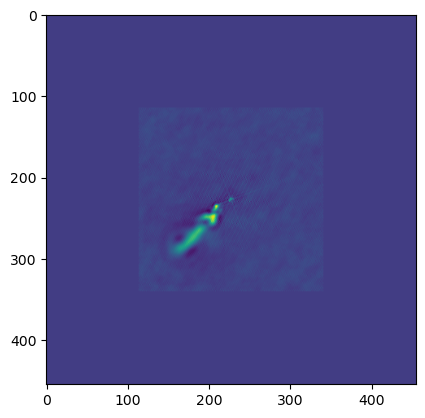

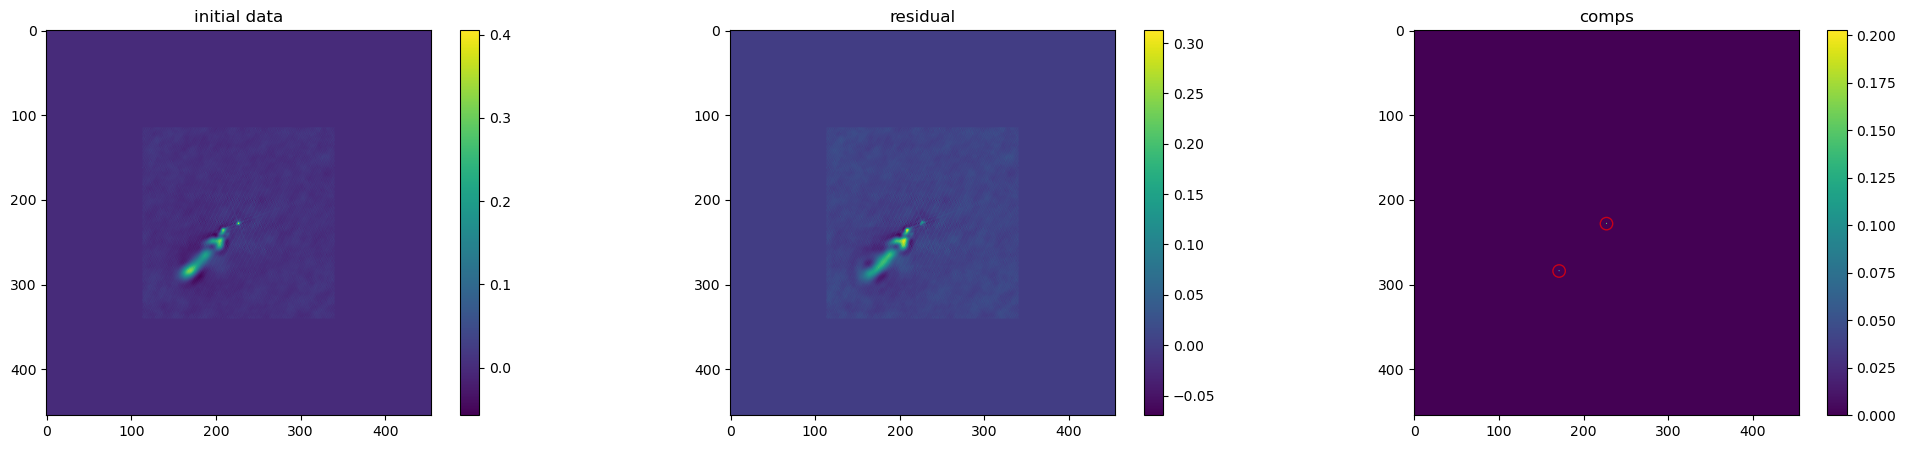

In [567]:
def CLEAN(dirty, gain, thresh, niter):
    global sec_per_frame, latency, delta
    """
    Hogbom clean, https://www.mrao.cam.ac.uk/~bn204/alma/python-clean.html

    :dirty: Изображение, подлежащее деконволюции
    :gain: Коэффициент усиления, т.е. доля самого яркого пикселя, которая удаляется на каждой итерации
    :thresh: Алгоритм прекращается при достижении максимального абсолютного отклонения остатка меньше этого значения
    :niter: Максимальное количество итераций, который необходимо провести, если пороговое значение "thresh" не достигнуто
    """
    comps=np.zeros(dirty.shape)
    res=np.array(dirty) 
    window=np.ones(dirty.shape, np.bool)
    
    tmp=0
    Cn2=[]
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 

    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res[window]), res.shape) # fabs? # нахождение максимального значения
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        t = sec_per_frame * latency
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        print('==============================================')
        print(f'Vx Vy: {Vx:.2f}, {Vy:.2f}') 
        print(f'gamma: {res[my, mx]}')
        print('==============================================')
     
        myParams = [(Vx, Vy, 1e-13, 10000)]
        psf, speckle_x, speckle_y, Cn2v = multi_speckle_fit(params=myParams, ydata=res)
        Cn2.append(Cn2v)

        
        res -= psf*gain

        cb = fig.colorbar(ax.imshow(res), ax=ax)
        display(fig)    
        clear_output(wait = True)
        a = str(input("Press [enter] to continue or type 'stop' to stop"))
        cb.remove() 
        if a == 'stop':
            break
    
        tmp+=1
#         if np.max(np.fabs(res)) < thresh:
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total interations:', tmp)
    return comps, res, Cn2


# =============================================
comps, residual, Cn2 = CLEAN(data, 0.5, 0.1, 50)
# =============================================
lambda_=650*pow(10, -9) # нм
k = 2*np.pi/lambda_
r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
print(' ')
# print('RMS:', np.sqrt(np.mean((data - fit)**2)))
print('sum Cn2:', np.sum(Cn2))
print('r0, sm:', 100*r0)
print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax2.imshow(residual), ax=ax2)
fig.colorbar(ax3.imshow(comps), ax=ax3)
a_tmp = np.where(comps!=0)
for i in range(len(a_tmp[0])):
    ax3.scatter(a_tmp[1][i], a_tmp[0][i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
ax.set_title('initial data')
ax2.set_title('residual')
ax3.set_title('comps')
print('')

C:\Users\miron\AppData\Local\Temp\ipykernel_13788\244231953.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window=np.ones(dirty.shape, np.bool)
C:\Users\miron\AppData\Local\Temp\ipykernel_13788\3307041047.py:55: RuntimeWarning: invalid value encountered in multiply
  res = tmp_res * S


Speckle fitting: 0.0 -0.27533039647577096 1e-13 10000
Fitted parametrs: 0.06 -0.34 9.999999999994757e-12 942.28
Time: 2.3473
-max fitted value: 0.54
-max initial value: 0.41

Speckle fitting: -15.418502202643172 -15.693832599118942 1e-13 10000
Fitted parametrs: -15.83 -15.55 6.435324573278793e-13 38212.17
Time: 4.9106
-max fitted value: 0.35
-max initial value: 0.33

Speckle fitting: -4.955947136563877 -2.4779735682819384 1e-13 10000
Fitted parametrs: -5.01 -2.67 2.514235964713109e-12 3588.92
Time: 3.6596
-max fitted value: 0.44
-max initial value: 0.33

Speckle fitting: -6.057268722466961 -6.332599118942732 1e-13 10000
Fitted parametrs: -6.55 -6.48 4.291246556896558e-13 21913.31
Time: 3.4090
-max fitted value: 0.32
-max initial value: 0.32

Speckle fitting: -5.78193832599119 -5.78193832599119 1e-13 10000
Fitted parametrs: -6.42 -6.48 3.31725282916774e-13 20396.43
Time: 5.9499
-max fitted value: 0.23
-max initial value: 0.32

Speckle fitting: -15.418502202643172 -15.693832599118942 1e-

Fitted parametrs: 3.00 -3.28 1.0000000000000003e-14 0.00
Time: 2.1010
-max fitted value: 0.00
-max initial value: 0.06

Speckle fitting: 0.0 -0.27533039647577096 1e-13 10000
Fitted parametrs: 3.00 -3.28 1.0000000000000002e-14 0.00
Time: 2.0903
-max fitted value: 0.00
-max initial value: 0.06

Speckle fitting: 0.0 -0.27533039647577096 1e-13 10000
Fitted parametrs: 3.00 -3.28 1.0000000000000002e-14 0.00
Time: 2.0820
-max fitted value: 0.00
-max initial value: 0.06

Speckle fitting: 0.0 -0.27533039647577096 1e-13 10000
Fitted parametrs: 3.00 -3.28 1.0000000000000003e-14 0.00
Time: 2.3045
-max fitted value: 0.00
-max initial value: 0.06

Total interations: 50
 
sum Cn2: 1.804326189198988e-11
r0, sm: 1.9412744285444798
seeing, arcsec: 6.76827567849403



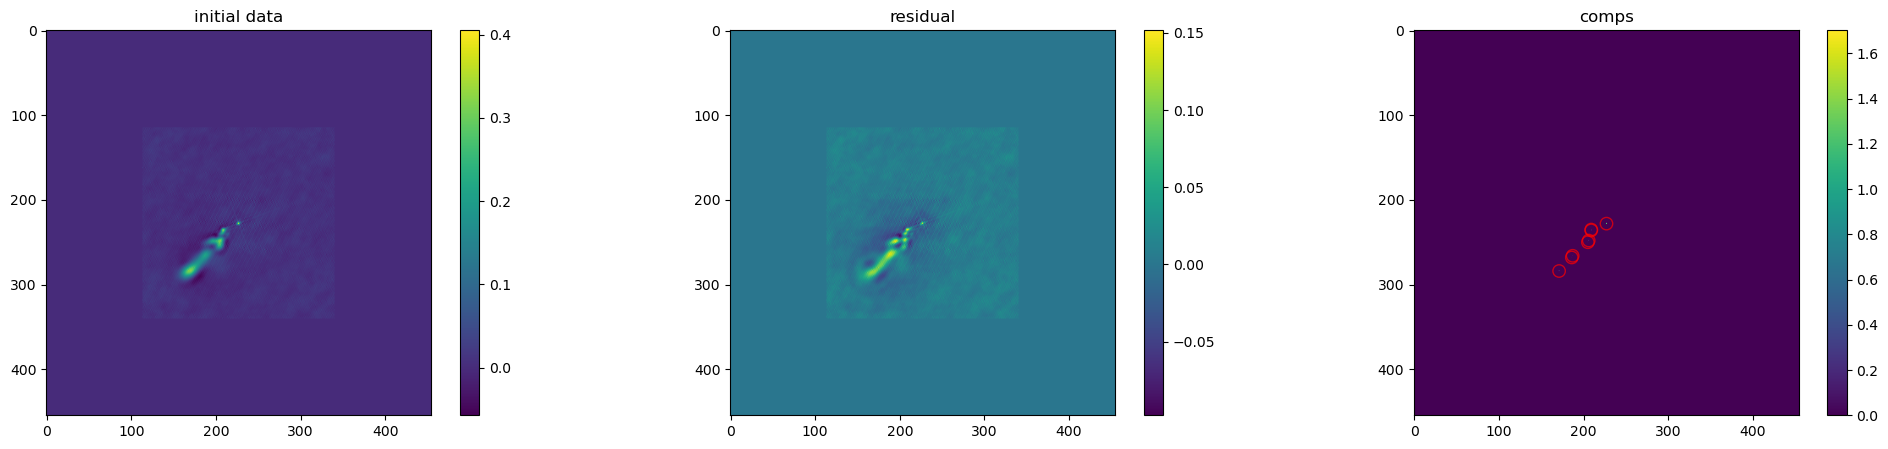

In [68]:
def CLEAN(dirty, gain, thresh, niter):
    global sec_per_frame, latency, delta
    """
    Hogbom clean, https://www.mrao.cam.ac.uk/~bn204/alma/python-clean.html

    :dirty: Изображение, подлежащее деконволюции
    :gain: Коэффициент усиления, т.е. доля самого яркого пикселя, которая удаляется на каждой итерации
    :thresh: Алгоритм прекращается при достижении максимального абсолютного отклонения остатка меньше этого значения
    :niter: Максимальное количество итераций, который необходимо провести, если пороговое значение "thresh" не достигнуто
    """
    comps=np.zeros(dirty.shape)
    res=np.array(dirty) 
    window=np.ones(dirty.shape, np.bool)
    
    tmp=0
    Cn2=[]
    z=[]

    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res[window]), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        t = sec_per_frame * latency
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t

     
        myParams = [(Vx, Vy, 1e-13, 10000)]
        psf, speckle_x, speckle_y, Cn2v, zv = multi_speckle_fit(params=myParams, ydata=res)
        Cn2.append(Cn2v)
        z.append(zv)

        
        res -= psf*gain
    
        tmp+=1
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total interations:', tmp)
    return comps, res, Cn2, z


# =============================================
comps, residual, Cn2, z = CLEAN(data, 0.3, 0.1, 50)
# =============================================
lambda_=650*pow(10, -9) # нм
k = 2*np.pi/lambda_
r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
print(' ')
# print('RMS:', np.sqrt(np.mean((data - fit)**2)))
print('sum Cn2:', np.sum(Cn2))
print('r0, sm:', 100*r0)
print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax2.imshow(residual), ax=ax2)
fig.colorbar(ax3.imshow(comps), ax=ax3)
a_tmp = np.where(comps!=0)
for i in range(len(a_tmp[0])):
    ax3.scatter(a_tmp[1][i], a_tmp[0][i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
ax.set_title('initial data')
ax2.set_title('residual')
ax3.set_title('comps')
print('')

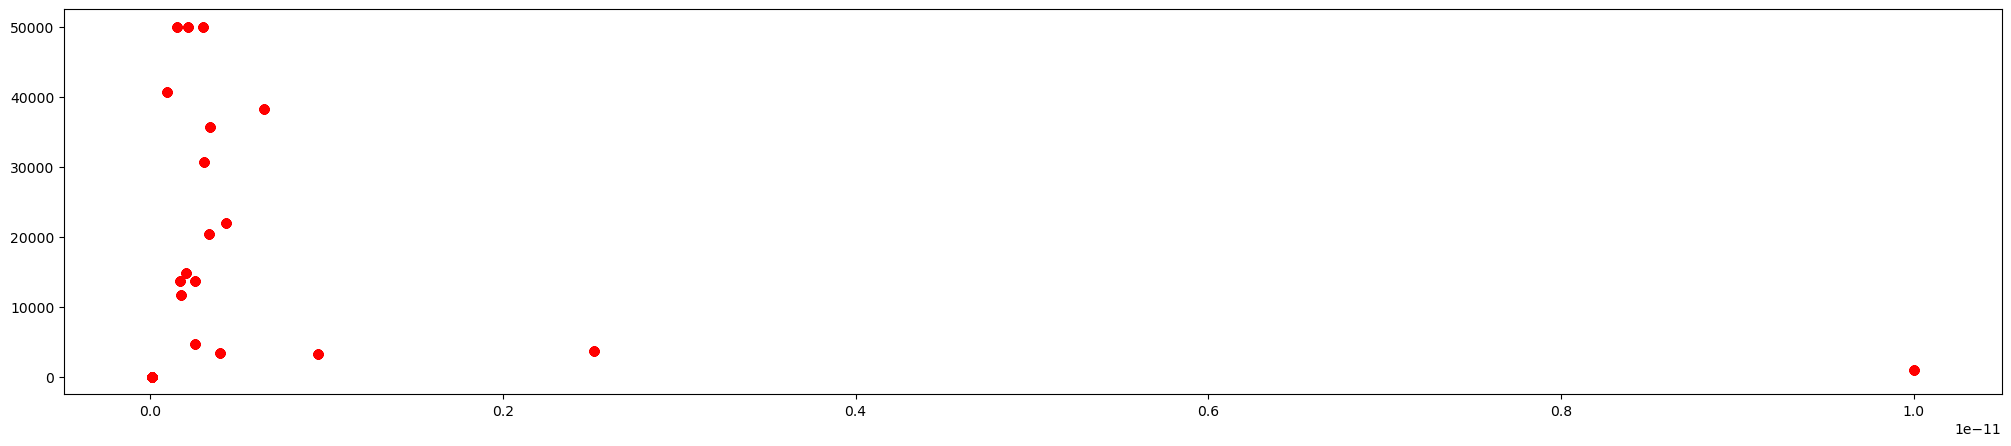

In [69]:
profile1 = np.stack((z, Cn2))
profile1 = profile1[:, profile1[0].argsort()]

fig, (ax) = plt.subplots(1, 1, figsize=(25, 5))

for i in range(len(profile1[0])):
    ax.scatter(profile1[1], profile1[0], color='red')